In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from models.autoencoder import AutoencoderDataset
from models.attention_unet import AttentionUNet
import os
import random

COMPRESSSED_DIM = 64

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
ad = AutoencoderDataset(DATA_DIR='./data', transform=torch.tensor)
print(ad.__len__())

train_generator = torch.Generator().manual_seed(SEED)
train, test = random_split(ad, [9/10, 1/10], generator=train_generator)

train_dl = DataLoader(train, batch_size=5, shuffle=True, worker_init_fn=lambda id: np.random.seed(SEED + id), generator=train_generator)
test_dl = DataLoader(test, batch_size=5, worker_init_fn=lambda id: np.random.seed(SEED + id), generator=train_generator)

113


In [4]:
os.system('mkdir -p ./checkpoints/attention_unet/')

global_step = 0
start_epoch = 0

writer = SummaryWriter()

model = AttentionUNet(ch_in=2, ch_out=2, compressed_dim=COMPRESSSED_DIM) 
model.double()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if global_step != 0:
    checkpoint_path = f'./checkpoints/attention_unet/{global_step}.pth'
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    
    torch.set_rng_state(checkpoint['torch_rng_state'])
    np.random.set_state(checkpoint['numpy_rng_state'])
    random.setstate(checkpoint['python_rng_state'])
    train_generator.set_state(checkpoint['generator_rng_state'])
    
    print(f"Resumed from checkpoint at epoch {start_epoch}, global step {global_step}")

num_epochs = 1500
min_loss = 1
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(train_dl):
        x, _ = data
        x = x.to(device)
        optimizer.zero_grad()
        output = model(x)
        train_loss = criterion(output, x)
        train_loss.backward()
        optimizer.step()

        global_step += 1

        if global_step % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch: {i}, Global Step: {global_step}, Train Loss: {train_loss.item():.4f}')
            torch.save({
                'epoch': epoch,
                'global_step': global_step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss.item(),
                'torch_rng_state': torch.get_rng_state(),
                'numpy_rng_state': np.random.get_state(),
                'python_rng_state': random.getstate(),
                'generator_rng_state': train_generator.get_state()
            }, f'./checkpoints/attention_unet/{global_step}.pth')
        
        writer.add_scalar('Loss/train', train_loss.item(), global_step=global_step)
    
    test_loss = 0

    for data in test_dl:
        x, _ = data
        x = x.to(device)
        output = model(x)
        test_loss += criterion(x, output).item()

    writer.add_scalar('Loss/test', test_loss, global_step=global_step)

Epoch [24/1500], Batch: 16, Global Step: 500, Train Loss: 0.0004
Epoch [48/1500], Batch: 12, Global Step: 1000, Train Loss: 0.0003
Epoch [72/1500], Batch: 8, Global Step: 1500, Train Loss: 0.0001
Epoch [96/1500], Batch: 4, Global Step: 2000, Train Loss: 0.0001
Epoch [120/1500], Batch: 0, Global Step: 2500, Train Loss: 0.0001
Epoch [143/1500], Batch: 17, Global Step: 3000, Train Loss: 0.0000
Epoch [167/1500], Batch: 13, Global Step: 3500, Train Loss: 0.0001
Epoch [191/1500], Batch: 9, Global Step: 4000, Train Loss: 0.0002
Epoch [215/1500], Batch: 5, Global Step: 4500, Train Loss: 0.0002
Epoch [239/1500], Batch: 1, Global Step: 5000, Train Loss: 0.0002
Epoch [262/1500], Batch: 18, Global Step: 5500, Train Loss: 0.0001
Epoch [286/1500], Batch: 14, Global Step: 6000, Train Loss: 0.0004
Epoch [310/1500], Batch: 10, Global Step: 6500, Train Loss: 0.0002
Epoch [334/1500], Batch: 6, Global Step: 7000, Train Loss: 0.0001
Epoch [358/1500], Batch: 2, Global Step: 7500, Train Loss: 0.0002
Epoch [3

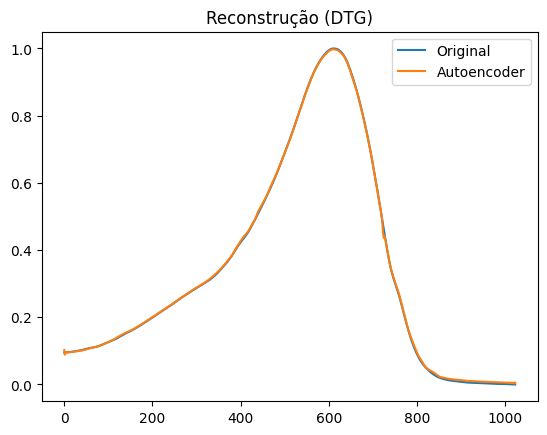

In [8]:
x, _ = next(iter(test_dl))
x = x.to(device)
best_model = AttentionUNet(ch_in=2, ch_out=2, compressed_dim=COMPRESSSED_DIM)
checkpoint = torch.load('./checkpoints/attention_unet/31500.pth', weights_only=False)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.to(device)
best_model.double()
best_model.eval()
plt.title('Reconstrução (DTG)')
plt.plot(x[0][1].cpu(), label='Original')
with torch.no_grad():
    y = best_model(x).detach().cpu().numpy()
plt.plot(y[0][1], label='Autoencoder')
plt.legend()
plt.show()
plt.close()

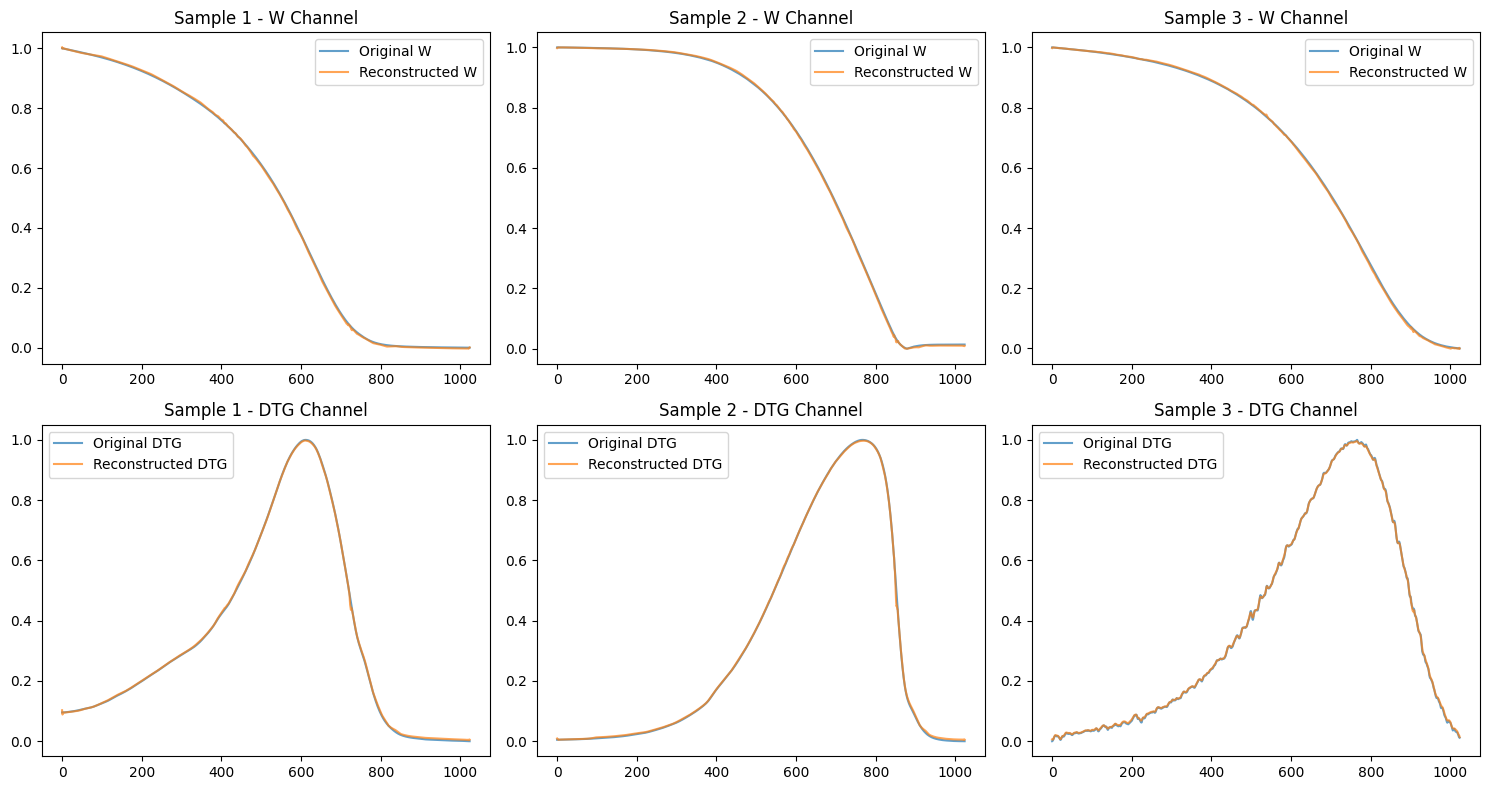

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
x, _ = next(iter(test_dl))
x = x.to(device)

best_model.eval()
with torch.no_grad():
    y = best_model(x).detach().cpu().numpy()
    
x_np = x.cpu().numpy()

for i in range(3):
    axes[0, i].plot(x_np[i, 0], label='Original W', alpha=0.7)
    axes[0, i].plot(y[i, 0], label='Reconstructed W', alpha=0.7)
    axes[0, i].set_title(f'Sample {i+1} - W Channel')
    axes[0, i].legend()
    
    axes[1, i].plot(x_np[i, 1], label='Original DTG', alpha=0.7)
    axes[1, i].plot(y[i, 1], label='Reconstructed DTG', alpha=0.7)
    axes[1, i].set_title(f'Sample {i+1} - DTG Channel')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

In [ ]:
os.system('mkdir -p ./encodings/')

ad = AutoencoderDataset(DATA_DIR='./data', transform=torch.tensor)
dl = DataLoader(ad, batch_size=1)

model = AttentionUNet(ch_in=2, ch_out=2, compressed_dim=COMPRESSSED_DIM)
checkpoint = torch.load('checkpoints/attention_unet/2500.pth', weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.double()
model.eval()

codes = None
with torch.no_grad(): 
    for x, _ in dl:
        x = x.to(device)
        code = model.encode(x).detach().cpu().numpy()
        codes = code if codes is None else np.concatenate([codes, code], axis=0)

np.savetxt('encodings/attention_unet_encoding.txt', codes)